RMSE: 0.2240, R2: 0.9887


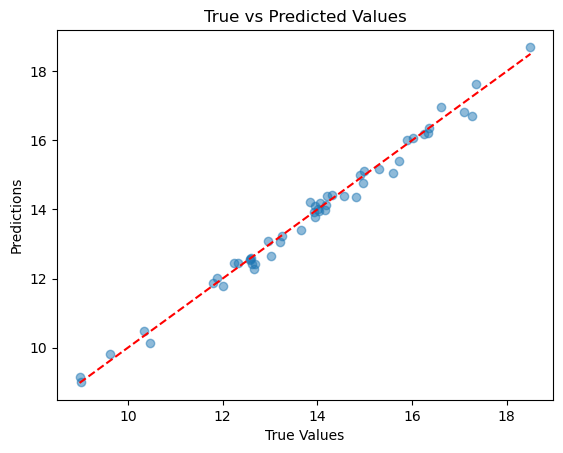

In [8]:
# ==============================================================
# Load packages and functions
# ==============================================================
import numpy as np
import pandas as pd
import torch
import os
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tabpfn import TabPFNRegressor, TabPFNClassifier

# Preprocessing functions
from preprocessing.process import  derivative

# ==============================================================
# Load TabPFN model
# ==============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ.setdefault("TABPFN_MODEL_CACHE_DIR",
                      r"D:\workspace\TabPFN\tabpfn") # set your local cache directory here

def load_local_tabpfn(kind="regressor", version="2.5", variant="real", device=device):
    """
    Load local TabPFN model (regressor or classifier).
    """
    cache = os.environ["TABPFN_MODEL_CACHE_DIR"]

    if version in ("2", "2.0"):
        fname = f"tabpfn-v2-{kind}.ckpt"
    elif version in ("2.5", "2_5"):
        var = (variant or "default").lower()
        fname = f"tabpfn-v2.5-{kind}-v2.5_{var}.ckpt"
    else:
        raise ValueError(f"Unsupported version: {version}")

    path = os.path.join(cache, fname)
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Model file not found: {path}")

    model_class = TabPFNRegressor if kind == "regressor" else TabPFNClassifier
    model = model_class(model_path=path, device=device, random_state=42)
    setattr(model, "ignore_pretraining_limits", True)

    return model


# ==============================================================
# Load dataset
# ==============================================================

# Your dataset path here
data_path = "D:/A/CSU/NIRdatasets/wheat/Test_ManufacturerA.xlsx" 
df = pd.read_excel(data_path)

# load spectra and labels
spectra = df.iloc[:, 2:743].values
y = df.iloc[:, 1].values

#split data into support and query sets
X_support, X_query, y_support, y_query = train_test_split(spectra, y, test_size=0.2, random_state=42)


# ==============================================================
# spectral processing 
# ==============================================================

X_support_deriv = derivative(X_support)
X_query_deriv = derivative(X_query)

# ==============================================================
# ICL and inference 
# ==============================================================

# Train a TabPFN model on the current fold
model = load_local_tabpfn(kind="regressor", version="2.5", variant="real") 
model.fit(X_support_deriv, y_support)
preds = model.predict(X_query_deriv)


# ==============================================================
# Evaluation
# ==============================================================

# Evaluate the model on the query set
rmse = np.sqrt(mean_squared_error(y_query, preds))
r2 = r2_score(y_query, preds)
print(f"RMSE: {rmse:.4f}, R2: {r2:.4f}")


# ==============================================================
# Plot True vs Predicted 
# ==============================================================

# Plot true vs predicted values
plt.scatter(y_query, preds, alpha=0.5)
plt.plot([min(y_query), max(y_query)], [min(y_query), max(y_query)], color='red', linestyle='--')
plt.title("True vs Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()